Scale Thresholding, Applying Filters, Transformations, Segmentation

The training set is used to fit the models; the validation set is used to estimate prediction error for model selection; the test set is used for assessment of the generalization error of the final chosen model. Ideally, the test set should be kept in a “vault,” and be brought out only at the end of the data analysis.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
#from PyTorch transfer learning tutorial nb
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [28]:
from pathlib import Path
from collections import Counter

In [5]:
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

# Training Data

To begin, we need to load the images in our training set. Essentially, we will make a list of paths to each image, and then use a separate function later to read the image file. 

I found these resources to be very helpful for learning how to load in image data

        https://docs.python.org/3/library/glob.html
        https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution

In [6]:
normal_path = train_dir / 'NORMAL'
pneumo_path = train_dir / 'PNEUMONIA'

#lists of the images
normal = normal_path.glob('*jpeg')
pneumo = pneumo_path.glob('*jpeg')

# we will store the normal images with a 0, pneumo with a 1
train = []
for x in normal:
    train.append((x,0))
for y in pneumo:
    train.append((y,1))

In [7]:
#lets take a look at this
train[:3]

[(WindowsPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg'), 0)]

In [8]:
train[-3:]

[(WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_39.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_40.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg'),
  1)]

This looks like what we wanted, a single list with the paths to the normal images at the beginning, and pnemo images at the end. 

In [9]:
#create a pandas dataframe from this list
trainDF = pd.DataFrame(train, columns = ['image','label'],index = None)

In [10]:
trainDF.head()

,image,label
0,..\data\chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,..\data\chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,..\data\chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,..\data\chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,..\data\chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


In [11]:
trainDF.tail()

,image,label
5211,..\data\chest_xray\train\PNEUMONIA\person99_vi...,1
5212,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5213,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5214,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5215,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1


In [12]:
 trainDF.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

So, in our training data, we have 3875 images where the patient has pneumonia, and 1341 where the person is normal. 

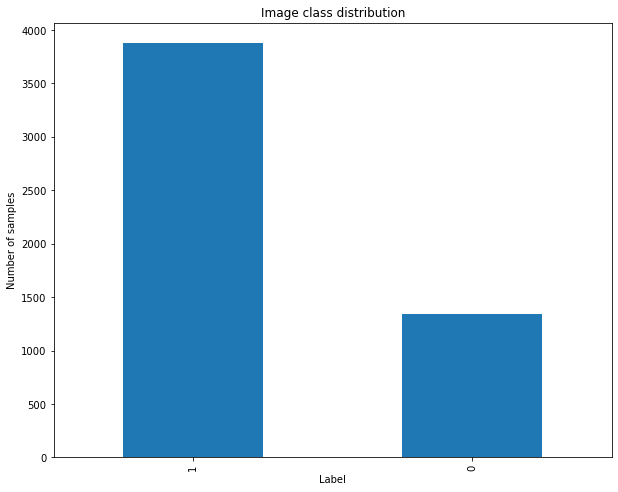

In [13]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

    https://www.kaggle.com/code/homayoonkhadivi/medical-diagnosis-with-cnn-transfer-learning

# Images in our training set

Here are 5 pictures of X-Ray's that were diagnosed with pneumonia

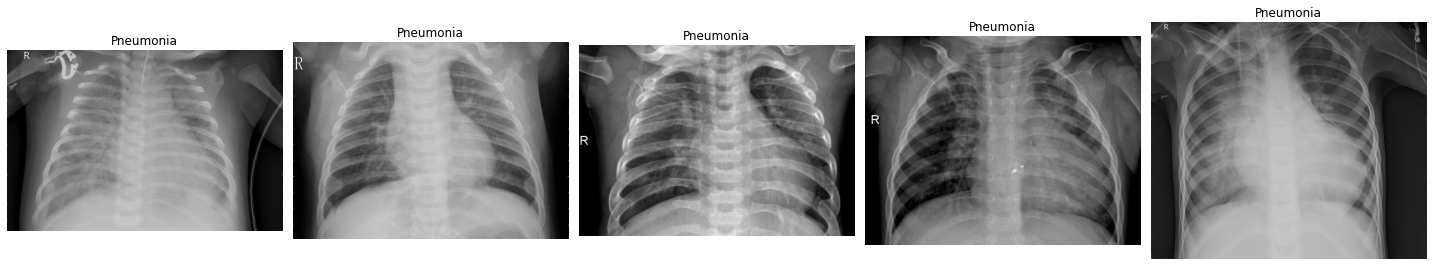

In [16]:
pneumo_pics = (trainDF[trainDF['label']==1]['image'].iloc[:5]).tolist()
#normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(pneumo_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Pneumonia")
    plt.axis('off')
    
plt.tight_layout()

In [17]:
pneumo_pics

[WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1003_bacteria_2934.jpeg')]

And here are 5 pictures of X-Ray's that were diagnosed as normal.

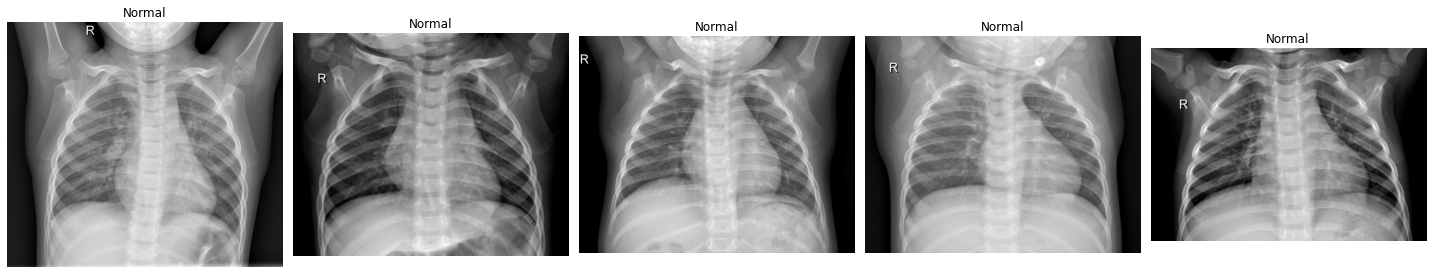

In [18]:
normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(normal_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Normal")
    plt.axis('off')
    
plt.tight_layout()

Lets take a look at a bigger version of a normal image, this time with the grayscale colorbar added

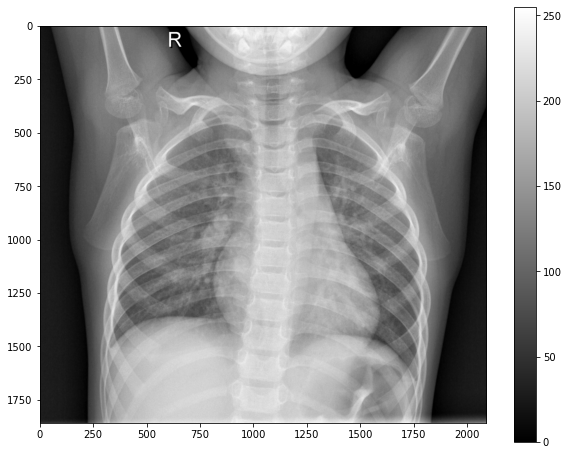

In [19]:
plt.figure(figsize = (10,8))
img = plt.imread(normal_pics[0])
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

In [20]:
img.shape

(1858, 2090)

In [21]:
#Lets see what some of the other image dimensions are. 

for i in range(5):
    img = plt.imread(normal_pics[i])
    print(img.shape)

(1858, 2090)
(1152, 1422)
(1434, 1810)
(1279, 1618)
(1125, 1600)


In [22]:
for i in range(5):
    img = plt.imread(pneumo_pics[i])
    print(img.shape)

(760, 1152)
(768, 1072)
(863, 1244)
(940, 1242)
(1280, 1488)


We will want to include resizing in our preprocessing to account for the differences in image size seen here. 

# Class Imbalance

There are several ways we could go about dealing with the class imbalance. We could generate more "Normal" images, and add them in to our current normal images a-priori. Or, we could write a function to generate images as we go on a batch by batch basis. 

Or, we could look at changing the weight in the loss function used in our actual model. Let's try a few different methods and compare results. Or, weighted random sampler. 

https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6

In [35]:
class_names = ['NORMAL', 'PNEUMONIA']

# Data Transformations

In [70]:
normal_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.5, 1.0)),
        transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [71]:
extra_normal1 = datasets.ImageFolder(train_dir, transform = normal_transforms)

In [72]:
len(extra_normal1)

5216

In [73]:
print(dict(Counter(extra_normal1.targets)))

{0: 1341, 1: 3875}


In [74]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler

torch.utils.data.WeightedRandomSampler(weights = [1,0], num_samples = 1341, replacement=False, generator=None)

Lets take a look at a batch of these images to see if these transforms create what we want to add. 

In [75]:
def imshow(inp, figsize = (20,20),title=None):
    """Imshow for Tensor.
    This function is modified from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [76]:
normDL1 = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

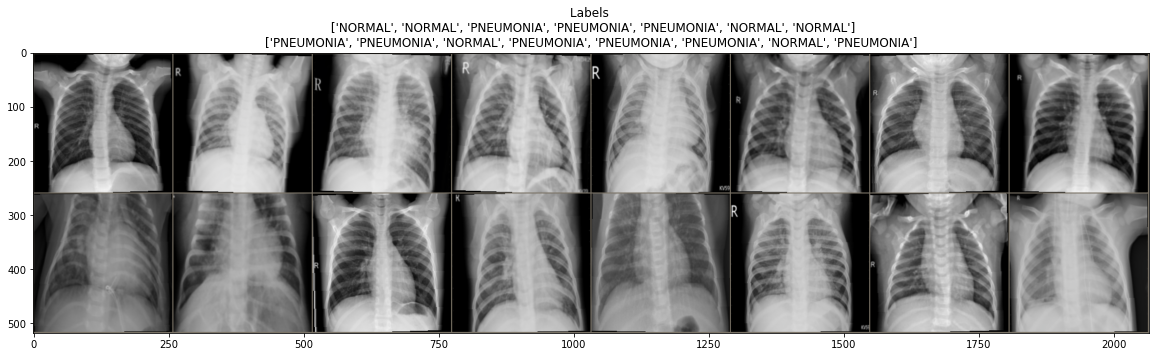

In [77]:
inputs,classes = next(iter(normDL1))
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

These look pretty good, they aren't "too" augmented (i.e. no big cropping, no reflections etc) so they still look like plausible x ray images, but the gaussian blur, brightness/exposure adjustments, and minor rotations should help bolster our training data. 

Note that because of the way we have our directories set up, we are going to create extra pnemo images as well, which we will need to separate when we re-load the saved images. 

In [86]:
extra_normal1[0].

(tensor([[[-1.7583, -1.7754, -1.7925,  ..., -0.5082, -0.5082, -0.5082],
          [-1.7583, -1.7754, -1.7925,  ..., -0.5082, -0.5082, -0.5082],
          [-1.7412, -1.7583, -1.7925,  ..., -0.5253, -0.5253, -0.5253],
          ...,
          [-1.6042, -1.6042, -1.6213,  ..., -0.9877, -0.9877, -0.9877],
          [-1.5014, -1.5014, -1.5014,  ..., -0.6623, -0.6452, -0.6281],
          [-1.3987, -1.3987, -1.3987,  ..., -0.3712, -0.3541, -0.3541]],
 
         [[-1.6681, -1.6856, -1.7031,  ..., -0.3901, -0.3901, -0.3901],
          [-1.6681, -1.6856, -1.7031,  ..., -0.3901, -0.3901, -0.3901],
          [-1.6506, -1.6681, -1.7031,  ..., -0.4076, -0.4076, -0.4076],
          ...,
          [-1.5105, -1.5105, -1.5280,  ..., -0.8803, -0.8803, -0.8803],
          [-1.4055, -1.4055, -1.4055,  ..., -0.5476, -0.5301, -0.5126],
          [-1.3004, -1.3004, -1.3004,  ..., -0.2500, -0.2325, -0.2325]],
 
         [[-1.4384, -1.4559, -1.4733,  ..., -0.1661, -0.1661, -0.1661],
          [-1.4384, -1.4559,

In [109]:
extra_normal1[1340][-1]

0

In [110]:
extra_normal1[1341][-1]

1

In [107]:
extra_normal1[0][-1]
#extra_normal1

0

Classes are stored as the last element

In [94]:
normal_transforms2 = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(1.0, 1.5)),
       # transforms.ColorJitter(hue=0),
        transforms.RandomAffine(degrees = 5),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [95]:
extra_normal2 = datasets.ImageFolder(train_dir, transform = normal_transforms)

In [96]:
normDL2 = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

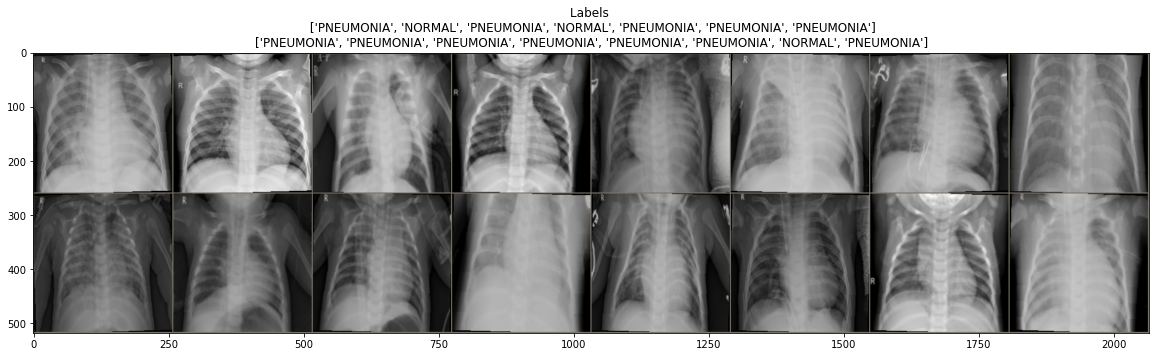

In [97]:
inputs,classes = next(iter(normDL2))
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

In [87]:
extra_normal1.classes

['NORMAL', 'PNEUMONIA']

save_image(img1, 'img1.png')

In [136]:
normDL = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

In [113]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [114]:
# augmentation and normalization for training
# only normalization for test

# normalization coefficients come from imagenet data? I think
#Maybe will try with and without then. 

#add transforms.RandomRotation(10) ?
# trandoms.RandomHorizontalFlip(), Resize()
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.1, 2.0)),
        #transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [115]:
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

In [116]:
train_data.classes

['NORMAL', 'PNEUMONIA']

In [118]:
#train_data[0]

In [119]:
3875-1341-1341

1193

In [123]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [124]:
type(extra_normal1)

torchvision.datasets.folder.ImageFolder

In [127]:
e1 = torch.utils.data.Subset(extra_normal1, list(range(1341)))


In [128]:
type(e1)

torch.utils.data.dataset.Subset

In [129]:
e2 = torch.utils.data.Subset(extra_normal2, list(range(1191)))

In [130]:
AUGdataset = ConcatDataset([train_data, e1, e2])


In [134]:
len(AUGdataset)

7748

In [144]:
AUGdataset[0][-1]

0

In [145]:
#takes a while so will keep commented out in future runs
#AUGcounts = [AUGdataset[i][-1] for i in range(len(AUGdataset))]

In [148]:
AUGco = dict(Counter(AUGcounts))

In [151]:
AUGco

{0: 3873, 1: 3875}

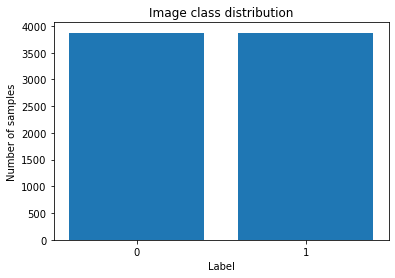

In [157]:
plt.bar(AUGco.keys(),AUGco.values())
plt.xlabel('Label')
plt.plot(figsize=(10,8))
plt.xticks([0,1])
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

In [160]:
class_names = train_data.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [161]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [153]:
print(dict(Counter(train_data.targets)))


{0: 1341, 1: 3875}


## DataLoader

In [163]:
total = len(AUGdataset)
print(total)

7748


In [165]:
train_size = int(0.8 * total)
val_size = total - train_size
train_data, val_data = torch.utils.data.random_split(AUGdataset, [train_size, val_size])

In [168]:
trainDL = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

In [169]:
valDL = DataLoader(val_data, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)

In [170]:
testDL = DataLoader(test_data, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)

In [172]:
dataloaders = {'train': trainDL, 'val':valDL, 'test':testDL}
    

Lets take a look at what a single batch from our training data looks like

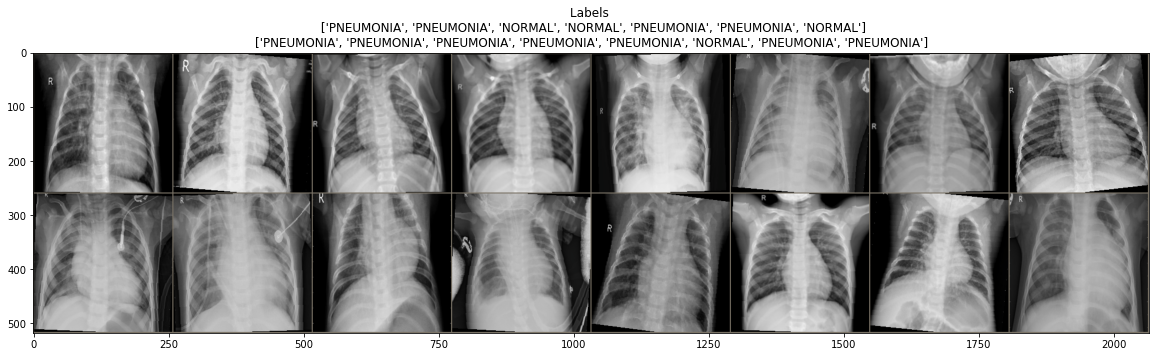

In [171]:
# Get a batch of training data
inputs, classes = next(iter(trainDL))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

In [178]:
dataset_sizes = {'train': len(train_data), 'val':len(val_data),'test': len(test_data)}

In [192]:
dataset_sizes

{'train': 6198, 'val': 1550, 'test': 624}

In [179]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Load in resnet18

In [175]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [193]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (8,8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.plot(figsize = (8,8))
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j],figsize = (6,6))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [180]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 0.0686 Acc: 0.9745
val Loss: 0.0290 Acc: 0.9903

Epoch 1/3
----------
train Loss: 0.0440 Acc: 0.9845
val Loss: 0.0291 Acc: 0.9903

Epoch 2/3
----------
train Loss: 0.0315 Acc: 0.9881
val Loss: 0.0215 Acc: 0.9929

Epoch 3/3
----------
train Loss: 0.0211 Acc: 0.9934
val Loss: 0.0342 Acc: 0.9929

Training complete in 3m 6s
Best val Acc: 0.992903


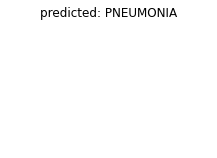

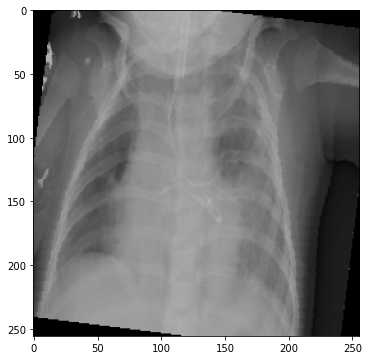

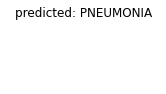

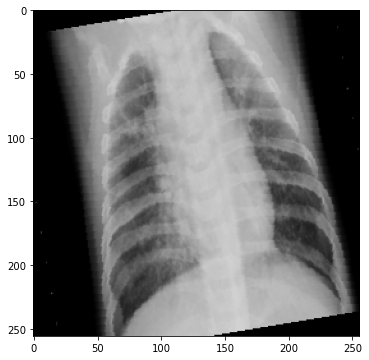

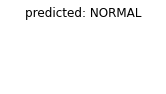

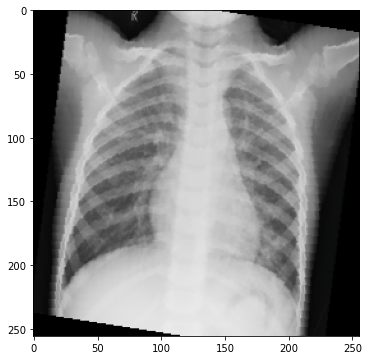

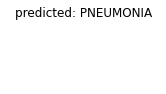

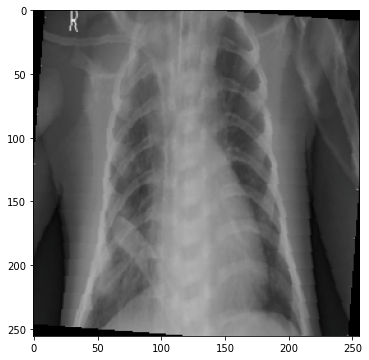

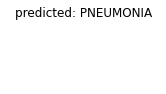

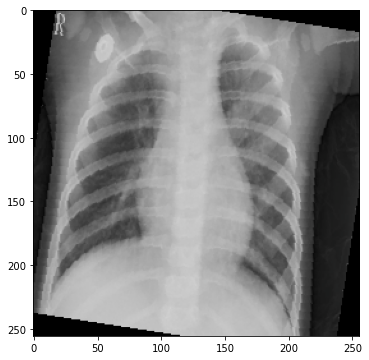

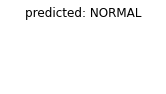

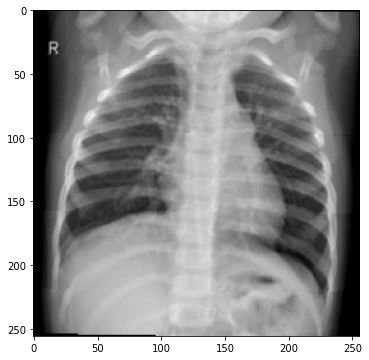

In [194]:
visualize_model(model_ft)

In [182]:
len(val_data)

1550

In [202]:
len(test_data)

624

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.1, 2.0)),
        #transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

In [201]:
dataloaders['test']

In [203]:
test_load = DataLoader(test_data, batch_size = 1)

In [204]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_ft(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [205]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [206]:
len(y_pred_list)

624

In [208]:
from sklearn.metrics import classification_report,accuracy_score


In [207]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.53      0.69       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



In [209]:
accuracy_score(y_true_list, y_pred_list)

0.8189102564102564

In [210]:
correct_count, all_count = 0, 0
for images,labels in test_load:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1, 3, 224, 224)
    with torch.no_grad():
        logps = model_ft(img)


    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count)) 

Number Of Images Tested = 624

Model Accuracy = 0.8189102564102564


In [ ]:
torch.save(model_ft.state_dict(), '../models/model1031')

In [ ]:
correct_count, all_count = 0, 0
for images,labels in testloader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1, 3, 224, 224)
    with torch.no_grad():
        logps = model(img)


    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

    batch_data[count] = orig_img
                batch_labels[count] = encoded_label

                # generating more samples of the undersampled class
                if label==0 and count < batch_size-2:
                    aug_img1 = seq.augment_image(img)
                    aug_img2 = seq.augment_image(img)
                    aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                    aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                    aug_img1 = aug_img1.astype(np.float32)/255.
                    aug_img2 = aug_img2.astype(np.float32)/255.

                    batch_data[count+1] = aug_img1
                    batch_labels[count+1] = encoded_label
                    batch_data[count+2] = aug_img2
                    batch_labels[count+2] = encoded_label
                    count +=2

                else:
                    count+=1

                if count==batch_size-1:
                    break

            i+=1
            yield batch_data, batch_labels

            if i>=steps:
                i=0

In [ ]:
torch.utils.data.WeightedRandomSampler(weights, num_samples = 7750, replacement=True, generator=None)

In [ ]:
#https://marekpaulik.medium.com/imbalanced-dataset-image-classification-with-pytorch-6de864982eb1
def load_data(self):
    train_full = torchvision.datasets.ImageFolder(self.data_dir, transform=self.Transform)
    train_set, val_set = random_split(train_full, [math.floor(len(train_full)*0.8), math.ceil(len(train_full)*0.2)])

    self.train_classes = [label for _, label in train_set]
    if self.sample:
        # Need to get weight for every image in the dataset
        class_count = Counter(self.train_classes)
        class_weights = torch.Tensor([len(self.train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
        # Can't iterate over class_count because dictionary is unordered

        sample_weights = [0] * len(train_set)
        for idx, (image, label) in enumerate(train_set):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight

        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples = len(train_set), replacement=True)  
        train_loader = DataLoader(train_set, batch_size=self.batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

    val_loader = DataLoader(val_set, batch_size=self.batch_size)

    return train_loader, val_loader

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    This function is from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [ ]:
#https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

#cool way to plot
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

AutoAugment is a common Data Augmentation technique that can improve the accuracy of Image Classification models. Though the data augmentation policies are directly linked to their trained dataset, empirical studies show that ImageNet policies provide significant improvements when applied to other datasets. In TorchVision we implemented 3 policies learned on the following datasets: ImageNet, CIFAR10 and SVHN. The new transform can be used standalone or mixed-and-matched with existing transforms:
    https://pytorch.org/vision/stable/transforms.html

    https://pytorch.org/vision/stable/feature_extraction.html

In [53]:
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import FCN_ResNet50_Weights
#, FCN_ResNet50_Weights
#model = fcn_resnet50()
weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in pnemo_pics[:5]])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

ImportError: cannot import name 'FCN_ResNet50_Weights' from 'torchvision.models.segmentation' (C:\Users\alber\anaconda3\lib\site-packages\torchvision\models\segmentation\__init__.py)

https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py

In [ ]:
# https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
# load all the image paths and randomly shuffle them
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(config.FLOWERS_DATASET_PATH))
np.random.shuffle(imagePaths)
# generate training and validation paths
valPathsLen = int(len(imagePaths) * config.VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen
trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]
# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, config.TRAIN)
copy_images(valPaths, config.VAL)



def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(config.BATCH_SIZE, config.BATCH_SIZE))
	# loop over the batch size
	for i in range(0, config.BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()
    
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))
# visualize the training and validation set batches
print("[INFO] visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

In [ ]:
#https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)